In [96]:
import sys
import os
import re
from typing import List

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [99]:
from config import settings as config

In [100]:
from src.data_processing.loading import load_data
from src.data_processing.transformation import date_format_change, extract_month_from_date
from src.data_processing.cleaning import clean_name, drop_columns
from src.data_processing.transformation import filter_by_state
from src.data_processing.validation import (
    get_dominant_district_per_pincode, 
    flag_multi_district_pincodes, 
    unique_pincode_count, 
    get_pin_district_count, 
    flag_problematic_enrolments, 
    aggregate_enrolments_by_district_pincode
)

Importing Enrolment Data Files

In [101]:
def load_data(file_paths : List[str]) -> pd.DataFrame:
    dfs = [] # List to hold individual DataFrames
    
    for file_path in file_paths:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
        
        print("*"*50)
        
        print(f"Loading file: {file_path}...")

        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
            print(f"Successfully loaded {file_path} with shape {df.shape}")
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
            raise

    if not dfs:
        return pd.DataFrame()  # Return empty DataFrame
    
    combined_df = pd.concat(dfs, axis=0, ignore_index=True)
    print("*"*50)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    return combined_df


In [102]:
enrolment_df = load_data(config.ENROLMENT_DATA_PATHS)

**************************************************
Loading file: c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_enrolment_0_500000.csv...
Successfully loaded c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_enrolment_0_500000.csv with shape (500000, 7)
**************************************************
Loading file: c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_enrolment_500000_1000000.csv...
Successfully loaded c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_enrolment_500000_1000000.csv with shape (500000, 7)
**************************************************
Loading file: c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_enrolment_1000000_1006029.csv...
Successfully loaded c:\Users\sahab\Desktop\uidi\data\raw\api_data_aadhar_enrolment_1000000_1006029.csv with shape (6029, 7)
**************************************************
Combined DataFrame shape: (1006029, 7)


In [103]:
print("Enrollment DataFrame:")
enrolment_df.head(10)

Enrollment DataFrame:


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21
5,09-03-2025,Bihar,Sitamarhi,843331,20,49,12
6,09-03-2025,Bihar,Sitamarhi,843330,23,24,42
7,09-03-2025,Uttar Pradesh,Bahraich,271865,26,60,14
8,09-03-2025,Uttar Pradesh,Firozabad,283204,28,26,10
9,09-03-2025,Bihar,Purbi Champaran,845418,30,48,10


In [104]:
def date_format_change(df: pd.DataFrame, date_column: str, new_format: str = '%Y%m%d') -> pd.DataFrame:
    """
    Change the format of a date column in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    date_column (str): The name of the date column to be reformatted.
    new_format (str): The desired date format. Default is '%Y%m%d'.

    Returns:
    pd.DataFrame: DataFrame with reformatted date column.
    """
    df[date_column] = pd.to_datetime(df['date'], format='%d-%m-%Y').dt.strftime(new_format)
    return df

In [105]:
date_format_change(enrolment_df, 'enrolment_date').head(10)

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37,20250302
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39,20250309
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,20250309
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15,20250309
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21,20250309
5,09-03-2025,Bihar,Sitamarhi,843331,20,49,12,20250309
6,09-03-2025,Bihar,Sitamarhi,843330,23,24,42,20250309
7,09-03-2025,Uttar Pradesh,Bahraich,271865,26,60,14,20250309
8,09-03-2025,Uttar Pradesh,Firozabad,283204,28,26,10,20250309
9,09-03-2025,Bihar,Purbi Champaran,845418,30,48,10,20250309


In [106]:
enrolment_df['state'].unique()

array(['Meghalaya', 'Karnataka', 'Uttar Pradesh', 'Bihar', 'Maharashtra',
       'Haryana', 'Rajasthan', 'Punjab', 'Delhi', 'Madhya Pradesh',
       'West Bengal', 'Assam', 'Uttarakhand', 'Gujarat', 'Andhra Pradesh',
       'Tamil Nadu', 'Chhattisgarh', 'Jharkhand', 'Nagaland', 'Manipur',
       'Telangana', 'Tripura', 'Mizoram', 'Jammu and Kashmir',
       'Chandigarh', 'Sikkim', 'Odisha', 'Kerala',
       'The Dadra And Nagar Haveli And Daman And Diu',
       'Arunachal Pradesh', 'Himachal Pradesh', 'Goa',
       'Jammu And Kashmir', 'Dadra and Nagar Haveli and Daman and Diu',
       'Ladakh', 'Andaman and Nicobar Islands', 'Orissa', 'Pondicherry',
       'Puducherry', 'Lakshadweep', 'Andaman & Nicobar Islands',
       'Dadra & Nagar Haveli', 'Dadra and Nagar Haveli', 'Daman and Diu',
       'WEST BENGAL', 'Jammu & Kashmir', 'West  Bengal', '100000',
       'Daman & Diu', 'West Bangal', 'Westbengal', 'West bengal',
       'andhra pradesh', 'ODISHA', 'WESTBENGAL'], dtype=object)

In [107]:
enrolment_df['state'].nunique()

55

In [108]:
def clean_name(df: pd.DataFrame, column_name: str, name_mapping: dict, cleaned_column_name: str) -> pd.DataFrame:
    """
    Clean and standardize names in a specified column of a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The name of the column to be cleaned.
    name_mapping (dict): A dictionary mapping incorrect names to correct names.
    cleaned_column_name (str): The name of the new column to store cleaned names.

    Returns:
    pd.DataFrame: DataFrame with an additional column for cleaned names.
    """
    def clean_single_name(name):
        if pd.isna(name):
            return name
        name = str(name).lower()                     # convert to lowercase
        name = re.sub(r'[^a-z0-9\s]', ' ', name)   # remove symbols like &, -, etc. (Regex pattern: [^a-z\s])
        name = re.sub(r'\s+', ' ', name).strip()  # remove extra spaces (Regex pattern: \s+)
        if re.fullmatch(r'\d+', name): # if name is purely numeric
            return None
        return name

    cleaned = df[column_name].apply(clean_single_name)
    df[cleaned_column_name] = cleaned.map(name_mapping).fillna(df[column_name])
    return df

In [109]:
state_mapping = {
    # West Bengal
    'west bengal': 'West Bengal',
    'west bangal': 'West Bengal',
    'westbengal': 'West Bengal',
    'west  bengal': 'West Bengal',
    'westbengal ': 'West Bengal',
    'west bengli':  'West Bengal',
    

    # Andhra Pradesh
    'andhra pradesh': 'Andhra Pradesh',

    # Odisha
    'odisha': 'Odisha',
    'orissa': 'Odisha',

    # Jammu & Kashmir
    'jammu and kashmir': 'Jammu and Kashmir',
    'jammu kashmir': 'Jammu and Kashmir',

    # Collapse all Dadra / Daman variants into ONE state
    'dadra nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli': 'Dadra and Nagar Haveli and Daman and Diu',
    'daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'dadra and nagar haveli and daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'the dadra and nagar haveli and daman and diu': 'Dadra and Nagar Haveli and Daman and Diu',
    'daman diu': 'Dadra and Nagar Haveli and Daman and Diu',


    # Puducherry
    'puducherry': 'Puducherry',


    # Andaman & Nicobar Islands
    'andaman and nicobar islands': 'Andaman and Nicobar Islands',
    'andaman nicobar islands': 'Andaman and Nicobar Islands',

    # Puducherry
    'pondicherry': 'Puducherry',

    # Case-normalized direct matches
    'delhi': 'Delhi',
    'ladakh': 'Ladakh',
    'goa': 'Goa',
    'sikkim': 'Sikkim',
    'assam': 'Assam',
    'bihar': 'Bihar',
    'punjab': 'Punjab',
    'kerala': 'Kerala',
    'haryana': 'Haryana',
    'gujarat': 'Gujarat',
    'tamil nadu': 'Tamil Nadu',
    'telangana': 'Telangana',
    'karnataka': 'Karnataka',
    'maharashtra': 'Maharashtra',
    'Nagpur': 'Maharashtra',
    'rajasthan': 'Rajasthan',
    'uttar pradesh': 'Uttar Pradesh',
    'madhya pradesh': 'Madhya Pradesh',
    'himachal pradesh': 'Himachal Pradesh',
    'arunachal pradesh': 'Arunachal Pradesh',
    'chhattisgarh': 'Chhattisgarh',
    'chhatisgarh' : 'Chhattisgarh',
    'jharkhand': 'Jharkhand',
    'manipur': 'Manipur',
    'meghalaya': 'Meghalaya',
    'mizoram': 'Mizoram',
    'nagaland': 'Nagaland',
    'tripura': 'Tripura',
    'uttarakhand': 'Uttarakhand',
    'lakshadweep': 'Lakshadweep',
    'chandigarh': 'Chandigarh'
}


In [110]:
clean_name(enrolment_df, 'state', config.STATE_MAPPING, 'state_cleaned').head(10)

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned
0,02-03-2025,Meghalaya,East Khasi Hills,793121,11,61,37,20250302,Meghalaya
1,09-03-2025,Karnataka,Bengaluru Urban,560043,14,33,39,20250309,Karnataka
2,09-03-2025,Uttar Pradesh,Kanpur Nagar,208001,29,82,12,20250309,Uttar Pradesh
3,09-03-2025,Uttar Pradesh,Aligarh,202133,62,29,15,20250309,Uttar Pradesh
4,09-03-2025,Karnataka,Bengaluru Urban,560016,14,16,21,20250309,Karnataka
5,09-03-2025,Bihar,Sitamarhi,843331,20,49,12,20250309,Bihar
6,09-03-2025,Bihar,Sitamarhi,843330,23,24,42,20250309,Bihar
7,09-03-2025,Uttar Pradesh,Bahraich,271865,26,60,14,20250309,Uttar Pradesh
8,09-03-2025,Uttar Pradesh,Firozabad,283204,28,26,10,20250309,Uttar Pradesh
9,09-03-2025,Bihar,Purbi Champaran,845418,30,48,10,20250309,Bihar


In [111]:
enrolment_df['state_cleaned'].unique()

array(['Meghalaya', 'Karnataka', 'Uttar Pradesh', 'Bihar', 'Maharashtra',
       'Haryana', 'Rajasthan', 'Punjab', 'Delhi', 'Madhya Pradesh',
       'West Bengal', 'Assam', 'Uttarakhand', 'Gujarat', 'Andhra Pradesh',
       'Tamil Nadu', 'Chhattisgarh', 'Jharkhand', 'Nagaland', 'Manipur',
       'Telangana', 'Tripura', 'Mizoram', 'Jammu and Kashmir',
       'Chandigarh', 'Sikkim', 'Odisha', 'Kerala',
       'Dadra and Nagar Haveli and Daman and Diu', 'Arunachal Pradesh',
       'Himachal Pradesh', 'Goa', 'Ladakh', 'Andaman and Nicobar Islands',
       'Puducherry', 'Lakshadweep', '100000'], dtype=object)

In [112]:
enrolment_df['state_cleaned'].nunique()

37

In [113]:
# Drop invalid entries like numeric junk
enrolment_df = enrolment_df[~enrolment_df['state'].astype(str).str.isnumeric()]

In [114]:
# enrolment_df.drop(enrolment_df[enrolment_df['state'] == '100000'].index, inplace=True)


In [115]:
enrolment_df['state_cleaned'].nunique()

36

In [116]:
enrolment_df.dtypes

date              object
state             object
district          object
pincode            int64
age_0_5            int64
age_5_17           int64
age_18_greater     int64
enrolment_date    object
state_cleaned     object
dtype: object

Cleaning Enrolment Data State Wise

In [117]:
def filter_by_state(df: pd.DataFrame, state_name: str, state_column: str = 'state_cleaned') -> pd.DataFrame:
    """
    Filter the DataFrame for a specific state.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    state_name (str): The name of the state to filter by.
    state_column (str): The name of the column containing state names. Default is 'state_cleaned'.

    Returns:
    pd.DataFrame: Filtered DataFrame containing only rows for the specified state.
    """
    filtered_df = df[df[state_column] == state_name]
    return filtered_df

In [118]:
wb_df = filter_by_state(enrolment_df, 'West Bengal')

In [119]:
wb_df.head(10)

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned
30,09-03-2025,West Bengal,Coochbehar,736135,19,12,19,20250309,West Bengal
32,09-03-2025,West Bengal,Dinajpur Uttar,733129,26,18,27,20250309,West Bengal
173,01-04-2025,West Bengal,Darjeeling,734010,81,49,17,20250401,West Bengal
199,01-04-2025,West Bengal,Cooch Behar,736135,243,127,20,20250401,West Bengal
208,01-04-2025,West Bengal,North 24 Parganas,700159,35,28,14,20250401,West Bengal
262,01-04-2025,West Bengal,Uttar Dinajpur,733134,484,109,27,20250401,West Bengal
281,01-04-2025,West Bengal,Jhargram,721517,40,10,12,20250401,West Bengal
303,01-04-2025,West Bengal,Darjeeling,734014,82,34,16,20250401,West Bengal
343,01-04-2025,West Bengal,Nadia,741502,204,33,11,20250401,West Bengal
390,01-04-2025,West Bengal,Jalpaiguri,735132,72,17,10,20250401,West Bengal


In [120]:
wb_df.shape

(76561, 9)

In [121]:
wb_df['district'].unique()

array(['Coochbehar', 'Dinajpur Uttar', 'Darjeeling', 'Cooch Behar',
       'North 24 Parganas', 'Uttar Dinajpur', 'Jhargram', 'Nadia',
       'Jalpaiguri', 'Alipurduar', 'Malda', 'Kolkata', 'Dakshin Dinajpur',
       'Kalimpong', 'Birbhum', '24 Paraganas North', 'Medinipur West',
       'Purba Bardhaman', 'Hooghly', '24 Paraganas South', 'Howrah',
       'Dinajpur Dakshin', 'Bankura', 'Barddhaman', 'Bardhaman',
       'Darjiling', 'East Midnapore', 'Haora', 'Koch Bihar', 'Maldah',
       'Murshidabad', 'North Twenty Four Parganas', 'Paschim Bardhaman',
       'Paschim Medinipur', 'Purba Medinipur', 'Purulia', 'Puruliya',
       'South 24 Parganas', 'South Dinajpur',
       'South Twenty Four Parganas', 'West Midnapore', 'Hugli',
       'North Dinajpur', 'HOOGHLY', 'NADIA', 'HOWRAH', 'Hawrah', 'MALDA',
       'hooghly', 'Medinipur', 'East Midnapur', 'nadia', 'Hooghiy',
       'KOLKATA', 'West Medinipur', 'Burdwan', 'South 24 parganas',
       'South 24 Pargana'], dtype=object)

In [122]:
wb_df['district'].nunique()

58

In [123]:
district_mapping_wb = {
    # Cooch Behar -> Koch Bihar
    'coochbehar': 'Koch Bihar',
    'cooch behar': 'Koch Bihar',
    'koch bihar': 'Koch Bihar',

    # Uttar Dinajpur -> Uttar Dinajpur
    'dinajpur uttar': 'Uttar Dinajpur',
    'uttar dinajpur': 'Uttar Dinajpur',
    'north dinajpur': 'Uttar Dinajpur',

    # Dakshin Dinajpur -> Dakshin Dinajpur
    'dinajpur dakshin': 'Dakshin Dinajpur',
    'dakshin dinajpur': 'Dakshin Dinajpur',
    'south dinajpur': 'Dakshin Dinajpur',

    # Darjeeling -> Darjiling
    'darjeeling': 'Darjiling',
    'darjiling': 'Darjiling',

    # Kalimpong -> Darjiling (Aggregated)
    'kalimpong': 'Darjiling',

    # Jalpaiguri -> Jalpaiguri
    'jalpaiguri': 'Jalpaiguri',

    # Alipurduar -> Jalpaiguri (Aggregated)
    'alipurduar': 'Jalpaiguri',

    # Malda -> Maldah
    'malda': 'Maldah',
    'maldah': 'Maldah',

    # Jhargram -> Paschim Medinipur (Aggregated)
    'jhargram': 'Paschim Medinipur',

    # Nadia -> Nadia
    'nadia': 'Nadia',

    # Murshidabad -> Murshidabad
    'murshidabad': 'Murshidabad',

    # Birbhum -> Birbhum
    'birbhum': 'Birbhum',

    # Bankura -> Bankura
    'bankura': 'Bankura',

    # Purulia -> Puruliya
    'purulia': 'Puruliya',
    'puruliya': 'Puruliya',

    # Kolkata -> Kolkata
    'kolkata': 'Kolkata',

    # Hooghly -> Hugli
    'hooghly': 'Hugli',
    'hugli': 'Hugli',
    'hooghiy': 'Hugli',

    # Howrah -> Haora
    'howrah': 'Haora',
    'haora': 'Haora',
    'hawrah': 'Haora',

    # North 24 Parganas -> North Twenty Four Parganas
    'north 24 parganas': 'North Twenty Four Parganas',
    '24 parganas north': 'North Twenty Four Parganas',
    '24 Paraganas North': 'North Twenty Four Parganas',
    'north twenty four parganas': 'North Twenty Four Parganas',
    'north 24 pgs': 'North Twenty Four Parganas',

    # South 24 Parganas -> South Twenty Four Parganas
    'south 24 parganas': 'South Twenty Four Parganas',
    '24 parganas south': 'South Twenty Four Parganas',
    'south twenty four parganas': 'South Twenty Four Parganas',
    'south 24 pargana': 'South Twenty Four Parganas',
    'south 24 pgs': 'South Twenty Four Parganas',

    # East Medinipur -> Purba Medinipur
    'east midnapore': 'Purba Medinipur',
    'east midnapur': 'Purba Medinipur',
    'purba medinipur': 'Purba Medinipur',

    # West Medinipur -> Paschim Medinipur
    'west midnapore': 'Paschim Medinipur',
    'west medinipur': 'Paschim Medinipur',
    'medinipur west': 'Paschim Medinipur',
    'paschim medinipur': 'Paschim Medinipur',

    # Bardhaman -> Purba/Paschim Barddhaman
    'bardhaman': 'Purba Barddhaman',
    'barddhaman': 'Purba Barddhaman',
    'burdwan': 'Purba Barddhaman',

    'purba bardhaman': 'Purba Barddhaman',
    'east bardhaman': 'Purba Barddhaman',
    'paschim bardhaman': 'Paschim Barddhaman',
    'west bardhaman': 'Paschim Barddhaman'
}

In [124]:
clean_name(wb_df, 'district', district_mapping_wb, 'district_cleaned').head(10)

C:\Users\sahab\AppData\Local\Temp\ipykernel_11408\2105690303.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[cleaned_column_name] = cleaned.map(name_mapping).fillna(df[column_name])


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned,district_cleaned
30,09-03-2025,West Bengal,Coochbehar,736135,19,12,19,20250309,West Bengal,Koch Bihar
32,09-03-2025,West Bengal,Dinajpur Uttar,733129,26,18,27,20250309,West Bengal,Uttar Dinajpur
173,01-04-2025,West Bengal,Darjeeling,734010,81,49,17,20250401,West Bengal,Darjiling
199,01-04-2025,West Bengal,Cooch Behar,736135,243,127,20,20250401,West Bengal,Koch Bihar
208,01-04-2025,West Bengal,North 24 Parganas,700159,35,28,14,20250401,West Bengal,North Twenty Four Parganas
262,01-04-2025,West Bengal,Uttar Dinajpur,733134,484,109,27,20250401,West Bengal,Uttar Dinajpur
281,01-04-2025,West Bengal,Jhargram,721517,40,10,12,20250401,West Bengal,Paschim Medinipur
303,01-04-2025,West Bengal,Darjeeling,734014,82,34,16,20250401,West Bengal,Darjiling
343,01-04-2025,West Bengal,Nadia,741502,204,33,11,20250401,West Bengal,Nadia
390,01-04-2025,West Bengal,Jalpaiguri,735132,72,17,10,20250401,West Bengal,Jalpaiguri


In [125]:
wb_df['district_cleaned'].unique()

array(['Koch Bihar', 'Uttar Dinajpur', 'Darjiling',
       'North Twenty Four Parganas', 'Paschim Medinipur', 'Nadia',
       'Jalpaiguri', 'Maldah', 'Kolkata', 'Dakshin Dinajpur', 'Birbhum',
       '24 Paraganas North', 'Purba Barddhaman', 'Hugli',
       '24 Paraganas South', 'Haora', 'Bankura', 'Purba Medinipur',
       'Murshidabad', 'Paschim Barddhaman', 'Puruliya',
       'South Twenty Four Parganas', 'Medinipur'], dtype=object)

In [126]:
wb_df['district_cleaned'].nunique()

23

In [127]:
wb_df['district_cleaned'] = wb_df['district_cleaned'].replace({
    '24 Paraganas North': 'North 24 Parganas',
    '24 Paraganas South': 'South 24 Parganas'
})

C:\Users\sahab\AppData\Local\Temp\ipykernel_11408\1780808684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb_df['district_cleaned'] = wb_df['district_cleaned'].replace({


In [128]:
wb_df['district_cleaned'].nunique()

23

PIN Code Mapping

In [129]:
def unique_pincode_count(df):
    return df.groupby('district_cleaned')['pincode'].nunique().reset_index(name='unique_pincode_count')

In [130]:
unique_pincode_count_df = unique_pincode_count(wb_df)

In [131]:
unique_pincode_count_df.head(24).sort_values(by='district_cleaned', ascending=True)

,district_cleaned,unique_pincode_count
0,Bankura,74
1,Birbhum,49
2,Dakshin Dinajpur,27
3,Darjiling,65
4,Haora,59
5,Hugli,106
6,Jalpaiguri,72
7,Koch Bihar,45
8,Kolkata,94
9,Maldah,39


In [132]:
def get_pin_district_count(df):
    return (
        df.groupby('pincode')['district_cleaned']
          .nunique()
          .reset_index(name='district_count')
    )

In [133]:
pin_district_count = get_pin_district_count(wb_df)
pin_district_count

,pincode,district_count
0,700001,1
1,700002,1
2,700003,1
3,700004,1
4,700005,1
...,...,...
1331,743702,1
1332,743704,1
1333,743710,1
1334,743711,2


In [134]:
problem_pins = pin_district_count[
    pin_district_count['district_count'] > 1
]

In [135]:
problem_pins

,pincode,district_count
7,700008,2
17,700018,2
23,700024,2
27,700028,2
29,700030,2
...,...,...
1302,743423,2
1304,743425,2
1317,743502,2
1327,743611,2


In [136]:
def flag_problematic_enrolments(enrolment_df, problem_pins_df):
    """
    Merge enrolment data with problematic pincodes to flag records.
    
    Parameters:
    enrolment_df (pd.DataFrame): The enrolment DataFrame to filter
    problem_pins_df (pd.DataFrame): DataFrame containing problematic pincodes
    
    Returns:
    pd.DataFrame: Filtered DataFrame containing only records with problematic pincodes
    """
    return enrolment_df.merge(
        problem_pins_df[['pincode']],
        on='pincode',
        how='inner'
    )

In [137]:
enrolment_flagged = flag_problematic_enrolments(wb_df, problem_pins)

In [138]:
enrolment_flagged

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned,district_cleaned
0,01-04-2025,West Bengal,Uttar Dinajpur,733123,158,29,10,20250401,West Bengal,Uttar Dinajpur
1,01-04-2025,West Bengal,North 24 Parganas,700102,42,23,12,20250401,West Bengal,North Twenty Four Parganas
2,01-05-2025,West Bengal,Uttar Dinajpur,733207,656,680,29,20250501,West Bengal,Uttar Dinajpur
3,01-05-2025,West Bengal,North 24 Parganas,743423,251,75,11,20250501,West Bengal,North Twenty Four Parganas
4,01-05-2025,West Bengal,North 24 Parganas,743145,74,52,12,20250501,West Bengal,North Twenty Four Parganas
...,...,...,...,...,...,...,...,...,...,...
20511,31-12-2025,West Bengal,Uttar Dinajpur,733207,22,23,0,20251231,West Bengal,Uttar Dinajpur
20512,31-12-2025,West Bengal,West Midnapore,721133,0,3,0,20251231,West Bengal,Paschim Medinipur
20513,31-12-2025,West Bengal,West Midnapore,721150,2,2,0,20251231,West Bengal,Paschim Medinipur
20514,31-12-2025,West Bengal,West Midnapore,721305,0,1,0,20251231,West Bengal,Paschim Medinipur


In [139]:
def aggregate_enrolments_by_district_pincode(df, age_columns=['age_0_5', 'age_5_17', 'age_18_greater']):
    """
    Aggregate enrolment counts by district and pincode.
    
    Parameters:
    df (pd.DataFrame): The enrolment DataFrame to aggregate
    age_columns (list): List of age group columns to sum. Default is ['age_0_5', 'age_5_17', 'age_18_greater']
    
    Returns:
    pd.DataFrame: Aggregated DataFrame with sums for each district-pincode combination
    """
    return df.groupby(['district_cleaned', 'pincode'])[age_columns].sum().reset_index()

In [140]:
flagged_pincode_dominant = aggregate_enrolments_by_district_pincode(
    flag_problematic_enrolments(wb_df, problem_pins))
flagged_pincode_dominant.head(10)

,district_cleaned,pincode,age_0_5,age_5_17,age_18_greater
0,Bankura,712612,3,0,0
1,Bankura,713142,9,1,0
2,Bankura,721504,94,4,0
3,Bankura,721515,1,0,0
4,Bankura,722134,310,28,5
5,Bankura,722138,227,18,2
6,Bankura,722140,342,67,4
7,Bankura,722145,82,11,0
8,Bankura,722150,347,30,2
9,Bankura,722153,48,27,1


In [141]:
def get_dominant_district_per_pincode(df, age_columns=['age_0_5', 'age_5_17', 'age_18_greater']):
    """
    Identify the dominant district for each pincode based on total enrollment.
    
    For pincodes that appear in multiple districts, this function calculates the total
    enrollment and returns only the district with the highest enrollment for each pincode.
    
    Parameters:
    df (pd.DataFrame): DataFrame with district_cleaned, pincode, and age group columns
    age_columns (list): List of age group columns to sum for total enrollment
    
    Returns:
    pd.DataFrame: Filtered DataFrame with one row per pincode (the dominant district)
    """
    # Calculate total enrollment
    df = df.copy()
    df['total_enroll'] = df[age_columns].sum(axis=1)
    
    # Get index of maximum enrollment for each pincode
    idx = df.groupby('pincode')['total_enroll'].idxmax()
    
    # Filter to keep only dominant districts
    df_filtered = df.loc[idx].sort_values('pincode')
    
    return df_filtered

In [142]:
def flag_multi_district_pincodes(df, pincode_column='pincode', district_column='district_cleaned', flag_column='pin_multi_district_flag'):
    """
    Flag records where a pincode appears in multiple districts.
    
    This function adds a boolean column to identify pincodes that are associated 
    with more than one district, which can indicate data quality issues.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame
    pincode_column (str): Name of the pincode column. Default is 'pincode'
    district_column (str): Name of the district column. Default is 'district_cleaned'
    flag_column (str): Name of the flag column to create. Default is 'pin_multi_district_flag'
    
    Returns:
    pd.DataFrame: DataFrame with the added flag column
    """
    df[flag_column] = (
        df.groupby(pincode_column)[district_column]
          .transform('nunique') > 1
    )
    return df

In [143]:
wb_df = flag_multi_district_pincodes(wb_df)

C:\Users\sahab\AppData\Local\Temp\ipykernel_11408\3977804115.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[flag_column] = (


In [144]:
wb_df

,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned,district_cleaned,pin_multi_district_flag
30,09-03-2025,West Bengal,Coochbehar,736135,19,12,19,20250309,West Bengal,Koch Bihar,False
32,09-03-2025,West Bengal,Dinajpur Uttar,733129,26,18,27,20250309,West Bengal,Uttar Dinajpur,False
173,01-04-2025,West Bengal,Darjeeling,734010,81,49,17,20250401,West Bengal,Darjiling,False
199,01-04-2025,West Bengal,Cooch Behar,736135,243,127,20,20250401,West Bengal,Koch Bihar,False
208,01-04-2025,West Bengal,North 24 Parganas,700159,35,28,14,20250401,West Bengal,North Twenty Four Parganas,False
...,...,...,...,...,...,...,...,...,...,...,...
1006024,31-12-2025,West Bengal,West Midnapore,721149,2,0,0,20251231,West Bengal,Paschim Medinipur,False
1006025,31-12-2025,West Bengal,West Midnapore,721150,2,2,0,20251231,West Bengal,Paschim Medinipur,True
1006026,31-12-2025,West Bengal,West Midnapore,721305,0,1,0,20251231,West Bengal,Paschim Medinipur,True
1006027,31-12-2025,West Bengal,West Midnapore,721504,1,0,0,20251231,West Bengal,Paschim Medinipur,True


In [145]:
wb_df['pin_multi_district_flag'].value_counts()

pin_multi_district_flag
False    56045
True     20516
Name: count, dtype: int64

In [146]:
wb_df['total_enroll']=wb_df['age_0_5']+wb_df['age_5_17']+wb_df['age_18_greater']
wb_df

C:\Users\sahab\AppData\Local\Temp\ipykernel_11408\518444026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wb_df['total_enroll']=wb_df['age_0_5']+wb_df['age_5_17']+wb_df['age_18_greater']


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned,district_cleaned,pin_multi_district_flag,total_enroll
30,09-03-2025,West Bengal,Coochbehar,736135,19,12,19,20250309,West Bengal,Koch Bihar,False,50
32,09-03-2025,West Bengal,Dinajpur Uttar,733129,26,18,27,20250309,West Bengal,Uttar Dinajpur,False,71
173,01-04-2025,West Bengal,Darjeeling,734010,81,49,17,20250401,West Bengal,Darjiling,False,147
199,01-04-2025,West Bengal,Cooch Behar,736135,243,127,20,20250401,West Bengal,Koch Bihar,False,390
208,01-04-2025,West Bengal,North 24 Parganas,700159,35,28,14,20250401,West Bengal,North Twenty Four Parganas,False,77
...,...,...,...,...,...,...,...,...,...,...,...,...
1006024,31-12-2025,West Bengal,West Midnapore,721149,2,0,0,20251231,West Bengal,Paschim Medinipur,False,2
1006025,31-12-2025,West Bengal,West Midnapore,721150,2,2,0,20251231,West Bengal,Paschim Medinipur,True,4
1006026,31-12-2025,West Bengal,West Midnapore,721305,0,1,0,20251231,West Bengal,Paschim Medinipur,True,1
1006027,31-12-2025,West Bengal,West Midnapore,721504,1,0,0,20251231,West Bengal,Paschim Medinipur,True,1


In [147]:
def extract_month_from_date(df, date_column='enrolment_date', month_column='month'):
    """
    Extract month from a date column and add it as a new column.
    
    Args:
        df: DataFrame containing the date column
        date_column: Name of the column containing the date (default: 'enrolment_date')
        month_column: Name of the new column to store the month (default: 'month')
    
    Returns:
        DataFrame with the new month column added
    """
    df[month_column] = df[date_column].astype(str).str[4:6]
    return df

In [148]:
extract_month_from_date(wb_df, 'enrolment_date').head(10)

C:\Users\sahab\AppData\Local\Temp\ipykernel_11408\875990809.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[month_column] = df[date_column].astype(str).str[4:6]


,date,state,district,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned,district_cleaned,pin_multi_district_flag,total_enroll,month
30,09-03-2025,West Bengal,Coochbehar,736135,19,12,19,20250309,West Bengal,Koch Bihar,False,50,03
32,09-03-2025,West Bengal,Dinajpur Uttar,733129,26,18,27,20250309,West Bengal,Uttar Dinajpur,False,71,03
173,01-04-2025,West Bengal,Darjeeling,734010,81,49,17,20250401,West Bengal,Darjiling,False,147,04
199,01-04-2025,West Bengal,Cooch Behar,736135,243,127,20,20250401,West Bengal,Koch Bihar,False,390,04
208,01-04-2025,West Bengal,North 24 Parganas,700159,35,28,14,20250401,West Bengal,North Twenty Four Parganas,False,77,04
262,01-04-2025,West Bengal,Uttar Dinajpur,733134,484,109,27,20250401,West Bengal,Uttar Dinajpur,False,620,04
281,01-04-2025,West Bengal,Jhargram,721517,40,10,12,20250401,West Bengal,Paschim Medinipur,False,62,04
303,01-04-2025,West Bengal,Darjeeling,734014,82,34,16,20250401,West Bengal,Darjiling,False,132,04
343,01-04-2025,West Bengal,Nadia,741502,204,33,11,20250401,West Bengal,Nadia,False,248,04
390,01-04-2025,West Bengal,Jalpaiguri,735132,72,17,10,20250401,West Bengal,Jalpaiguri,False,99,04


In [149]:
def drop_columns(df, columns_to_drop: list):
    """
    Drop specified columns from a DataFrame.
    
    Args:
        df: DataFrame to clean
        columns_to_drop: List of column names to drop
    
    Returns:
        DataFrame with specified columns removed
    """
    return df.drop(columns=columns_to_drop, axis=1)

In [150]:
wb_df_cleaned = drop_columns(wb_df, ['date','district','state'])

In [151]:
wb_df_cleaned

,pincode,age_0_5,age_5_17,age_18_greater,enrolment_date,state_cleaned,district_cleaned,pin_multi_district_flag,total_enroll,month
30,736135,19,12,19,20250309,West Bengal,Koch Bihar,False,50,03
32,733129,26,18,27,20250309,West Bengal,Uttar Dinajpur,False,71,03
173,734010,81,49,17,20250401,West Bengal,Darjiling,False,147,04
199,736135,243,127,20,20250401,West Bengal,Koch Bihar,False,390,04
208,700159,35,28,14,20250401,West Bengal,North Twenty Four Parganas,False,77,04
...,...,...,...,...,...,...,...,...,...,...
1006024,721149,2,0,0,20251231,West Bengal,Paschim Medinipur,False,2,12
1006025,721150,2,2,0,20251231,West Bengal,Paschim Medinipur,True,4,12
1006026,721305,0,1,0,20251231,West Bengal,Paschim Medinipur,True,1,12
1006027,721504,1,0,0,20251231,West Bengal,Paschim Medinipur,True,1,12


In [152]:
wb_df_dist_level=wb_df_cleaned.groupby('district_cleaned')[['age_0_5','age_5_17','age_18_greater','total_enroll']].sum().sort_values(by='total_enroll', ascending=False).reset_index()

In [153]:
wb_df_dist_level.shape

(23, 5)

In [154]:
wb_df_dist_level

,district_cleaned,age_0_5,age_5_17,age_18_greater,total_enroll
0,Uttar Dinajpur,25138,13065,702,38905
1,South Twenty Four Parganas,28020,9323,308,37651
2,Murshidabad,31442,4383,86,35911
3,North Twenty Four Parganas,22743,6140,1350,30233
4,Paschim Medinipur,16954,4707,223,21884
5,Purba Barddhaman,16686,3824,145,20655
6,Koch Bihar,11629,6418,439,18486
7,Nadia,13249,3624,843,17716
8,Maldah,12979,4523,84,17586
9,Purba Medinipur,14751,1628,62,16441


In [ ]:
// wb_df_dist_level.to_excel("wb_enrolment_df_dist_level.xlsx") 

In [156]:
wb_df_dist_level_f10 = wb_df_dist_level.head(10)

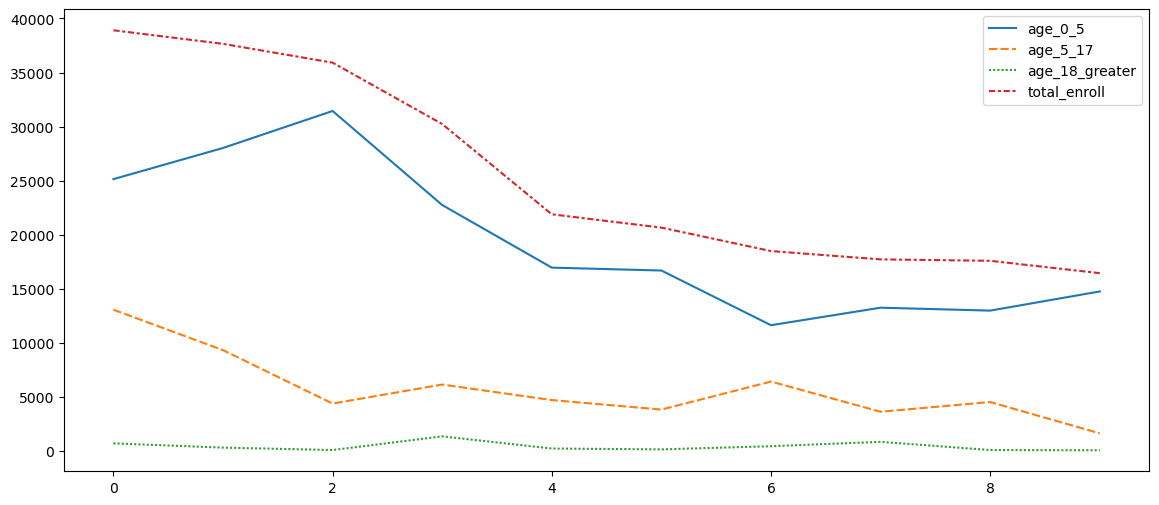

In [157]:
plt.figure(figsize=(14, 6))   # width, height in inches
sns.lineplot(data= wb_df_dist_level_f10[['age_0_5','age_5_17','age_18_greater', 'total_enroll']])
plt.show()

In [158]:
wb_df_pincode_level=wb_df_cleaned.groupby('pincode')[['age_0_5','age_5_17','age_18_greater','total_enroll']].sum().sort_values(by='total_enroll', ascending=False).reset_index()

In [159]:
wb_df_pincode_level.head(10)

,pincode,age_0_5,age_5_17,age_18_greater,total_enroll
0,733207,4533,3821,121,8475
1,733202,3978,2787,73,6838
2,733210,4101,1907,20,6028
3,743329,3014,1509,21,4544
4,733201,2602,1133,47,3782
5,736135,2187,1443,113,3743
6,742202,3247,461,2,3710
7,733134,2188,638,72,2898
8,743423,1901,493,149,2543
9,733129,1339,724,273,2336


In [ ]:
# wb_df_pincode_level.to_excel("wb_enrolment_df_pincode_level.xlsx") 

In [161]:
wb_df_pincode_level_f10 = wb_df_pincode_level.head(10)

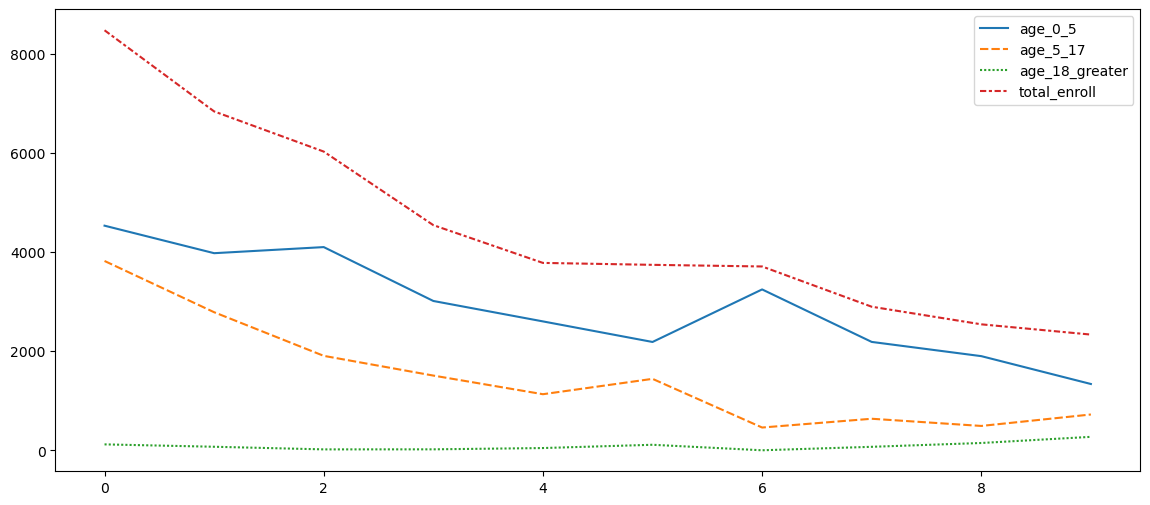

In [162]:
plt.figure(figsize=(14, 6))   # width, height in inches
sns.lineplot(data= wb_df_pincode_level_f10[['age_0_5','age_5_17','age_18_greater', 'total_enroll']])
plt.show()

In [163]:
def filter_df_by_level(df: pd.DataFrame, filter_by: str, filter_label: List[str]) -> pd.DataFrame:
    """
    Aggregate and filter DataFrame by a specified grouping column.
    
    Groups the DataFrame by a specified column, sums the specified label columns,
    and returns the results sorted by total enrollment in descending order.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame to aggregate
    filter_by (str): The column name to group by (e.g., 'month', 'district_cleaned')
    filter_label (List[str]): List of column names to sum (e.g., ['age_0_5', 'age_5_17', 'age_18_greater', 'total_enroll'])
    
    Returns:
    pd.DataFrame: Aggregated DataFrame sorted by 'total_enroll' in descending order
    """
    return df.groupby(filter_by)[filter_label].sum().sort_values(by='total_enroll', ascending=False).reset_index()

In [164]:
wb_df_month_level = filter_df_by_level(wb_df_cleaned, 'month', ['age_0_5','age_5_17','age_18_greater','total_enroll'])

In [165]:
wb_df_month_level

,month,age_0_5,age_5_17,age_18_greater,total_enroll
0,09,91195,27328,1134,119657
1,11,61020,17967,249,79236
2,10,60423,17270,199,77892
3,12,35858,9321,3590,48769
4,07,15274,11657,1613,28544
5,05,5538,3500,544,9582
6,06,3194,3323,754,7271
7,04,2873,1014,381,4268
8,03,45,30,46,121


In [166]:
wb_df_month_level=wb_df_cleaned.groupby('month')[['age_0_5','age_5_17','age_18_greater','total_enroll']].sum().sort_values(by='month', ascending=True).reset_index()

In [167]:
wb_df_month_level

,month,age_0_5,age_5_17,age_18_greater,total_enroll
0,03,45,30,46,121
1,04,2873,1014,381,4268
2,05,5538,3500,544,9582
3,06,3194,3323,754,7271
4,07,15274,11657,1613,28544
5,09,91195,27328,1134,119657
6,10,60423,17270,199,77892
7,11,61020,17967,249,79236
8,12,35858,9321,3590,48769


<Axes: >

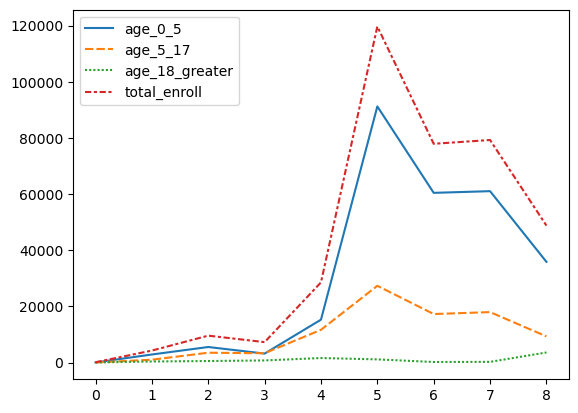

In [168]:
sns.lineplot(data=wb_df_month_level[['age_0_5','age_5_17','age_18_greater', 'total_enroll']])

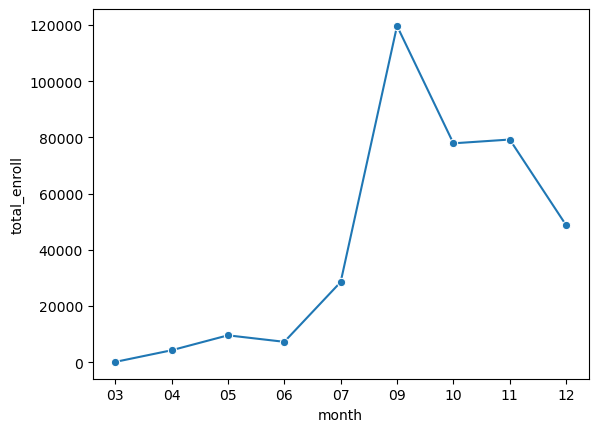

In [169]:
sns.lineplot(data=wb_df_month_level, x='month', y='total_enroll', marker='o')
plt.show()

In [ ]:
# wb_df_month_level.to_excel("wb_enrolment_df_month_level.xlsx") 

In [171]:
wb_df_dist_level = wb_df_dist_level[wb_df_dist_level["district_cleaned"] != "Medinipur"]


In [ ]:
wb_df_dist_level.to_excel("wb_enrolment_df_dist_level_filtered.xlsx")

# Plot District Level Heat Map for West Bengal Enrolment

This notebook merges enrolment data from an Excel file with a GeoJSON of West Bengal districts to produce a choropleth map.

In [173]:
%pip install geopandas matplotlib descartes openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [174]:
import geopandas as gpd

In [175]:
# File paths
excel_path = 'wb_enrolment_df_dist_level_filtered.xlsx'
geojson_path = '../data/raw/west_bengal_districts.geojson'
output_image = '../results/wb_enrolment_heatmap.png'

os.makedirs('../results', exist_ok=True)

In [176]:
# 1. Load Data
print("Loading Excel data...")
df = pd.read_excel(excel_path)
df.head(23)
# print("Excel DataFrame loaded.")
# # Auto-detect district column in Excel
# excel_dist_col = None
# for col in df.columns:
#     if 'district' in str(col).lower() or 'dist_name' in str(col).lower():
#         excel_dist_col = col
#         break
# if not excel_dist_col:
#     # Fallback: look for object column with unique count > 10
#     for col in df.select_dtypes(include=['object']).columns:
#         if df[col].nunique() > 10:
#              excel_dist_col = col
#              break

# if excel_dist_col:
#     print(f"Detected Excel district column: {excel_dist_col}")
#     df['district_normalized'] = df[excel_dist_col].astype(str).str.upper().str.strip()
# else:
#     raise ValueError("Could not detect district column in Excel file.")

Loading Excel data...


,Unnamed: 0,district_cleaned,age_0_5,age_5_17,age_18_greater,total_enroll
0,0,Uttar Dinajpur,25138,13065,702,38905
1,1,South Twenty Four Parganas,28020,9323,308,37651
2,2,Murshidabad,31442,4383,86,35911
3,3,North Twenty Four Parganas,22743,6140,1350,30233
4,4,Paschim Medinipur,16954,4707,223,21884
5,5,Purba Barddhaman,16686,3824,145,20655
6,6,Koch Bihar,11629,6418,439,18486
7,7,Nadia,13249,3624,843,17716
8,8,Maldah,12979,4523,84,17586
9,9,Purba Medinipur,14751,1628,62,16441


In [177]:
df.columns

Index(['Unnamed: 0', 'district_cleaned', 'age_0_5', 'age_5_17',
       'age_18_greater', 'total_enroll'],
      dtype='object')

In [178]:
df.select_dtypes(include=['object'])

,district_cleaned
0,Uttar Dinajpur
1,South Twenty Four Parganas
2,Murshidabad
3,North Twenty Four Parganas
4,Paschim Medinipur
5,Purba Barddhaman
6,Koch Bihar
7,Nadia
8,Maldah
9,Purba Medinipur


In [179]:
df.select_dtypes(include=['object']).columns

Index(['district_cleaned'], dtype='object')

In [180]:
print("Excel DataFrame loaded.")
# Auto-detect district column in Excel
excel_dist_col = None
for col in df.columns:
    if 'district' in str(col).lower() or 'dist_name' in str(col).lower():
        excel_dist_col = col
        break
if not excel_dist_col:
    # Fallback: look for object column with unique count > 10
    for col in df.select_dtypes(include=['object']).columns:
        if df[col].nunique() > 10:
             excel_dist_col = col
             break

if excel_dist_col:
    print(f"Detected Excel district column: {excel_dist_col}")
    df['district_normalized'] = df[excel_dist_col].astype(str).str.upper().str.strip()
else:
    raise ValueError("Could not detect district column in Excel file.")

excel_dist_col

Excel DataFrame loaded.
Detected Excel district column: district_cleaned


'district_cleaned'

In [181]:
df.head(23)

,Unnamed: 0,district_cleaned,age_0_5,age_5_17,age_18_greater,total_enroll,district_normalized
0,0,Uttar Dinajpur,25138,13065,702,38905,UTTAR DINAJPUR
1,1,South Twenty Four Parganas,28020,9323,308,37651,SOUTH TWENTY FOUR PARGANAS
2,2,Murshidabad,31442,4383,86,35911,MURSHIDABAD
3,3,North Twenty Four Parganas,22743,6140,1350,30233,NORTH TWENTY FOUR PARGANAS
4,4,Paschim Medinipur,16954,4707,223,21884,PASCHIM MEDINIPUR
5,5,Purba Barddhaman,16686,3824,145,20655,PURBA BARDDHAMAN
6,6,Koch Bihar,11629,6418,439,18486,KOCH BIHAR
7,7,Nadia,13249,3624,843,17716,NADIA
8,8,Maldah,12979,4523,84,17586,MALDAH
9,9,Purba Medinipur,14751,1628,62,16441,PURBA MEDINIPUR


In [182]:
# 2. Load GeoJSON
print("Loading GeoJSON...")
try:
    gdf = gpd.read_file(geojson_path)
    print("GeoJSON loaded.")
except Exception as e:
    print(f"Failed to load GeoJSON: {e}")
    raise

gdf.head()

# # Auto-detect district column in GeoJSON
# geo_dist_col = None
# potential_cols = ['dtname', 'district', 'DISTRICT', 'NAME_2', 'Name', 'NAME_1', 'district_name', 'District', 'sdtname']
# for col in potential_cols:
#     if col in gdf.columns:
#         geo_dist_col = col
#         break

# # Data content check if name not matched
# if not geo_dist_col:
#     print("Searching columns by content...")
#     # Check if any column contains 'KOLKATA' or 'DARJEELING' (case insensitive)
#     target_districts = ['KOLKATA', 'DARJEELING', 'HOWRAH']
#     for col in gdf.columns:
#         if gdf[col].dtype == 'object':
#             sample_vals = gdf[col].astype(str).str.upper().tolist()
#             if any(t in sample_vals for t in target_districts):
#                 geo_dist_col = col
#                 break

# if geo_dist_col:
#     print(f"Detected GeoJSON district column: {geo_dist_col}")
#     gdf['district_normalized'] = gdf[geo_dist_col].astype(str).str.upper().str.strip()
# else:
#     print("Columns:", gdf.columns.tolist())
#     print(gdf.head())
#     raise ValueError("Could not detect district column in GeoJSON.")


Loading GeoJSON...
GeoJSON loaded.


,ISO,FIPS,DHSCC,SVYTYPE,SVYYEAR,CNTRYNAMEE,CNTRYNAMEF,CNTRYNAMES,DHSREGEN,DHSREGFR,...,OTHREGNA,LEVELCO,LEVELNA,REPALLIND,REGNOTES,SVYNOTES,state_name,district_name,reg_code,geometry
0,IN,IN,IA,DHS,2020,India,{},{},Kolkata,{},...,West Bengal,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Kolkata,342,"MULTIPOLYGON (((88.3806 22.6278, 88.3886 22.62..."
1,IN,IN,IA,DHS,2020,India,{},{},Darjiling,{},...,West Bengal,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Darjiling,327,"MULTIPOLYGON (((88.1269 27.1231, 88.1366 27.11..."
2,IN,IN,IA,DHS,2020,India,{},{},Jalpaiguri,{},...,West Bengal,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Jalpaiguri,328,"MULTIPOLYGON (((88.6254 26.4054, 88.6211 26.40..."
3,IN,IN,IA,DHS,2020,India,{},{},Koch Bihar,{},...,West Bengal,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Koch Bihar,329,"MULTIPOLYGON (((88.7963 26.2214, 88.7962 26.21..."
4,IN,IN,IA,DHS,2020,India,{},{},Uttar Dinajpur,{},...,West Bengal,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Uttar Dinajpur,330,"MULTIPOLYGON (((88.3314 26.4958, 88.333 26.496..."


In [183]:
# Auto-detect district column in GeoJSON
geo_dist_col = None
potential_cols = ['dtname', 'district', 'DISTRICT', 'NAME_2', 'Name', 'NAME_1', 'district_name', 'District', 'sdtname']
for col in potential_cols:
    if col in gdf.columns:
        geo_dist_col = col
        break

geo_dist_col

# # Data content check if name not matched
# if not geo_dist_col:
#     print("Searching columns by content...")
#     # Check if any column contains 'KOLKATA' or 'DARJEELING' (case insensitive)
#     target_districts = ['KOLKATA', 'DARJEELING', 'HOWRAH']
#     for col in gdf.columns:
#         if gdf[col].dtype == 'object':
#             sample_vals = gdf[col].astype(str).str.upper().tolist()
#             if any(t in sample_vals for t in target_districts):
#                 geo_dist_col = col
#                 break

# if geo_dist_col:
#     print(f"Detected GeoJSON district column: {geo_dist_col}")
#     gdf['district_normalized'] = gdf[geo_dist_col].astype(str).str.upper().str.strip()
# else:
#     print("Columns:", gdf.columns.tolist())
#     print(gdf.head())
#     raise ValueError("Could not detect district column in GeoJSON.")


'district_name'

In [184]:
# Data content check if name not matched
if not geo_dist_col:
    print("Searching columns by content...")
    # Check if any column contains 'KOLKATA' or 'DARJEELING' (case insensitive)
    target_districts = ['KOLKATA', 'DARJEELING', 'HOWRAH']
    for col in gdf.columns:
        if gdf[col].dtype == 'object':
            sample_vals = gdf[col].astype(str).str.upper().tolist()
            if any(t in sample_vals for t in target_districts):
                geo_dist_col = col
                break
geo_dist_col

# if geo_dist_col:
#     print(f"Detected GeoJSON district column: {geo_dist_col}")
#     gdf['district_normalized'] = gdf[geo_dist_col].astype(str).str.upper().str.strip()
# else:
#     print("Columns:", gdf.columns.tolist())
#     print(gdf.head())
#     raise ValueError("Could not detect district column in GeoJSON.")


'district_name'

In [185]:
if geo_dist_col:
    print(f"Detected GeoJSON district column: {geo_dist_col}")
    gdf['district_normalized'] = gdf[geo_dist_col].astype(str).str.upper().str.strip()
else:
    print("Columns:", gdf.columns.tolist())
    print(gdf.head())
    raise ValueError("Could not detect district column in GeoJSON.")

Detected GeoJSON district column: district_name


In [186]:
gdf.head()

,ISO,FIPS,DHSCC,SVYTYPE,SVYYEAR,CNTRYNAMEE,CNTRYNAMEF,CNTRYNAMES,DHSREGEN,DHSREGFR,...,LEVELCO,LEVELNA,REPALLIND,REGNOTES,SVYNOTES,state_name,district_name,reg_code,geometry,district_normalized
0,IN,IN,IA,DHS,2020,India,{},{},Kolkata,{},...,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Kolkata,342,"MULTIPOLYGON (((88.3806 22.6278, 88.3886 22.62...",KOLKATA
1,IN,IN,IA,DHS,2020,India,{},{},Darjiling,{},...,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Darjiling,327,"MULTIPOLYGON (((88.1269 27.1231, 88.1366 27.11...",DARJILING
2,IN,IN,IA,DHS,2020,India,{},{},Jalpaiguri,{},...,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Jalpaiguri,328,"MULTIPOLYGON (((88.6254 26.4054, 88.6211 26.40...",JALPAIGURI
3,IN,IN,IA,DHS,2020,India,{},{},Koch Bihar,{},...,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Koch Bihar,329,"MULTIPOLYGON (((88.7963 26.2214, 88.7962 26.21...",KOCH BIHAR
4,IN,IN,IA,DHS,2020,India,{},{},Uttar Dinajpur,{},...,Admin2,Districts,yes,{},Survey is representative at 2 levels: 36 Admin...,West Bengal,Uttar Dinajpur,330,"MULTIPOLYGON (((88.3314 26.4958, 88.333 26.496...",UTTAR DINAJPUR


Merged shape: (20, 38)
Unmatched districts: 0
Plot saved to ../results/wb_enrolment_heatmap.png


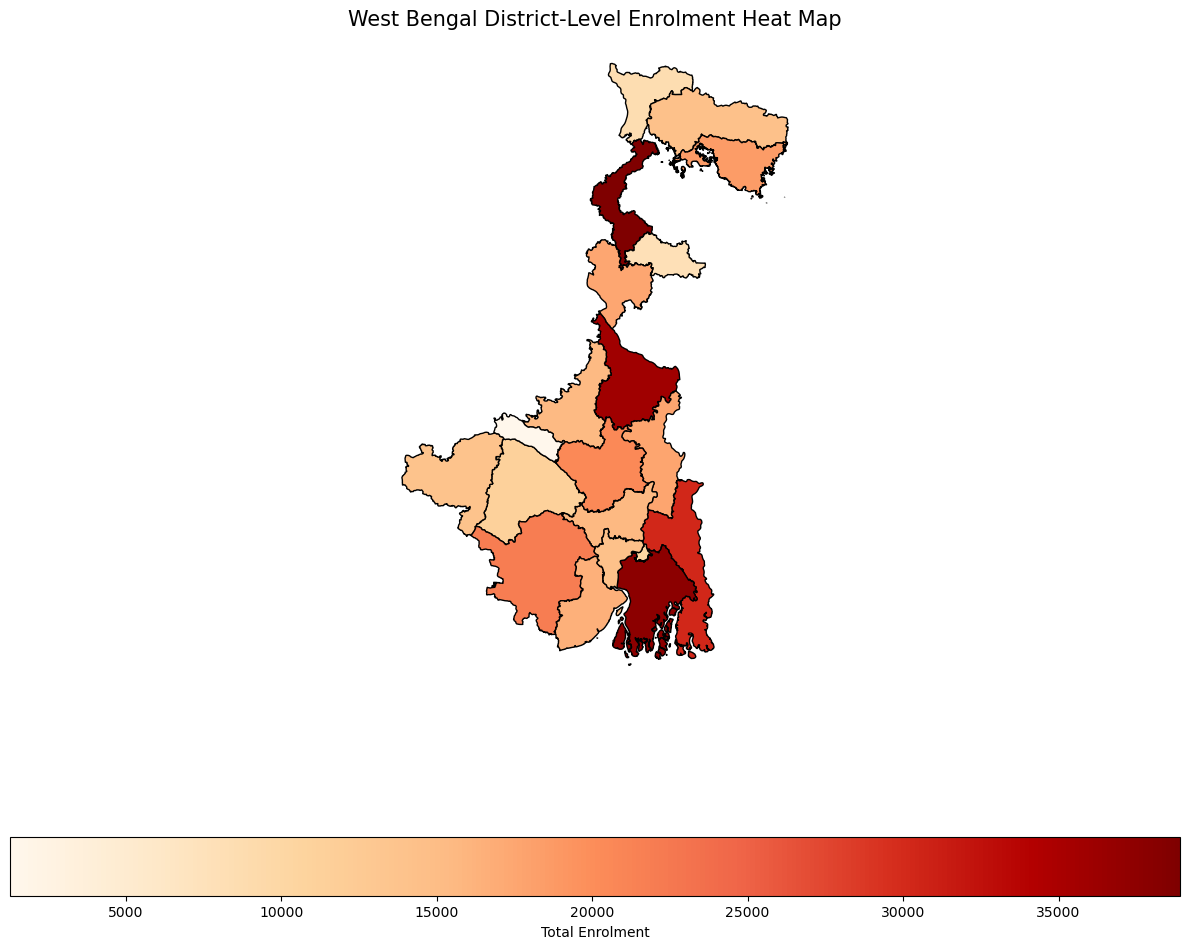

In [187]:
output_image = '../results/wb_enrolment_heatmap.png'
# 3. Merge
merged = gdf.merge(df, on='district_normalized', how='left')
print(f"Merged shape: {merged.shape}")
print(f"Unmatched districts: {len(merged[merged['total_enroll'].isna()])}")

gdf.head()

# 4. Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='total_enroll', ax=ax, legend=True,
            legend_kwds={'label': "Total Enrolment", 'orientation': "horizontal"},
            cmap='OrRd', edgecolor='black', missing_kwds={'color': 'lightgrey'})

plt.title('West Bengal District-Level Enrolment Heat Map', fontsize=15)
plt.axis('off')
plt.tight_layout()
# plt.savefig(output_image, dpi=300)
print(f"Plot saved to {output_image}")

Plot saved to ../results/wb_enrolment_heatmap.png


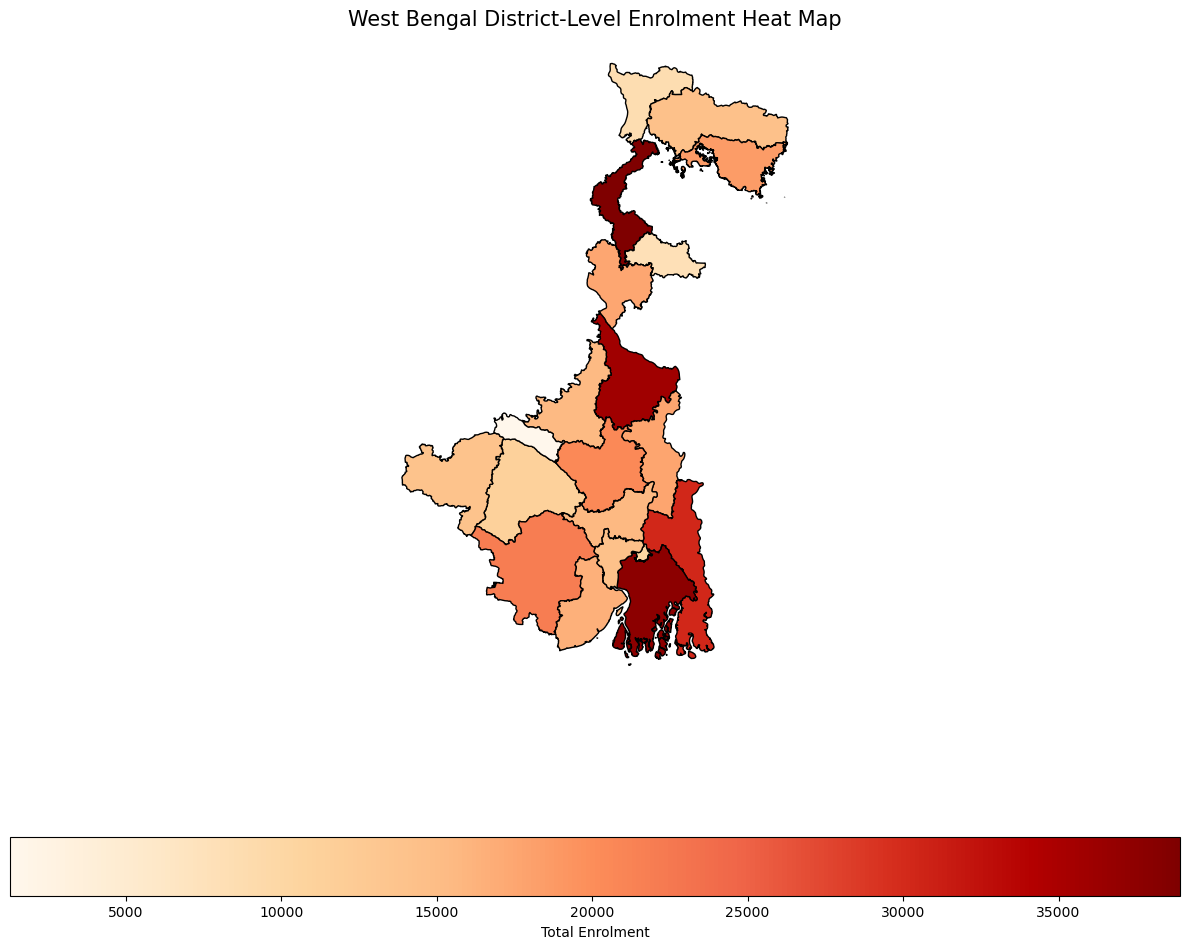

In [188]:
output_image = '../results/wb_enrolment_heatmap.png'
# 4. Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
merged.plot(column='total_enroll', ax=ax, legend=True,
            legend_kwds={'label': "Total Enrolment", 'orientation': "horizontal"},
            cmap='OrRd', edgecolor='black', missing_kwds={'color': 'lightgrey'})

plt.title('West Bengal District-Level Enrolment Heat Map', fontsize=15)
plt.axis('off')
plt.tight_layout()
# plt.savefig(output_image, dpi=300)
print(f"Plot saved to {output_image}")

In [189]:
# Generic Function to Plot Enrolment Heatmap for Any State
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import os

def plot_state_enrolment_heatmap(enrolment_df, state_name, geojson_path, output_path, district_mapping=None):
    """
    Generates and saves an enrolment heatmap for a specific state.
    
    Args:
        enrolment_df (pd.DataFrame): The raw enrolment dataframe containing 'state', 'district', 'total_enroll'.
        state_name (str): Name of the state to filter and plot (e.g., 'West Bengal').
        geojson_path (str): Path to the state's district GeoJSON file.
        output_path (str): Path where the resulting PNG plot will be saved.
        district_mapping (dict, optional): Dictionary to map/correct district names before merging.
    """
    print(f"Processing data for {state_name}...")
    
    # 1. Filter Data for State
    # Ensure state filtering is case-insensitive if needed, or rely on exact match if data is clean
    state_df = enrolment_df[enrolment_df['state_cleaned'] == state_name].copy()
    
    if state_df.empty:
        print(f"No records found for state: {state_name}")
        return
        
    # 2. Clean District Names
    # Basic cleaning: lowercase and strip
    state_df['district_cleaned'] = state_df['district'].astype(str).str.lower().str.strip()
    
    # 3. Apply Mapping if provided
    if district_mapping:
        print("Applying district mapping...")
        state_df['district_cleaned'] = state_df['district_cleaned'].map(district_mapping).fillna(state_df['district_cleaned'])
        
        # Capitalize for better matching if no mapping found (heuristic)
        # But if mapping maps to Title Case, we are good. 
        # Let's ensure the mapping values are Title Case if that's what GeoJSON has.
    
    # 4. Group by District
    dist_df = state_df.groupby('district_cleaned')['total_enroll'].sum().reset_index()
    
    # 5. Load GeoJSON
    if not os.path.exists(geojson_path):
        print(f"GeoJSON file not found at: {geojson_path}")
        return
        
    gdf = gpd.read_file(geojson_path)
    
    # Find district column in GeoJSON
    dist_col = None
    possible_cols = ['district', 'DISTRICT', 'dtname', 'DTNAME', 'district_name', 'Name', 'NAME', 'District']
    for col in possible_cols:
        if col in gdf.columns:
            dist_col = col
            break
            
    if not dist_col:
        print("Could not identify district column in GeoJSON. Available columns:", gdf.columns)
        return
        
    # Normalize GeoJSON district names for merging
    # We create a normalized column for merging, keeping original for geometry
    gdf['district_normalized'] = gdf[dist_col].astype(str).str.strip()
    # Note: We rely on the mapping to match this normalized name. 
    # If mapping outputs 'Paschim Medinipur', GeoJSON must have 'Paschim Medinipur'.
    
    # 6. Merge
    # We merge on the cleaned/mapped name from DF and the normalized name from GeoJSON
    merged = gdf.merge(dist_df, left_on='district_normalized', right_on='district_cleaned', how='left')
    
    # Check for unmatched
    unmatched_count = merged['total_enroll'].isna().sum()
    if unmatched_count > 0:
        print(f"Warning: {unmatched_count} districts in GeoJSON have no matching enrolment data.")
        unmatched_districts = merged[merged['total_enroll'].isna()]['district_normalized'].tolist()
        print("Unmatched districts:", unmatched_districts)
    
    # 7. Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    # Plot all districts with base color (grey for missing data)
    merged.plot(column='total_enroll', ax=ax, legend=True,
                legend_kwds={'label': "Total Enrolment by District",
                             'orientation': "horizontal"},
                missing_kwds={'color': 'lightgrey', 'label': 'Missing values'},
                cmap='YlOrRd',
                edgecolor='black')
                
    plt.title(f'{state_name} Enrolment Heatmap', fontsize=16)
    plt.axis('off')
    
    # Save
    output_dir = os.path.dirname(output_path)
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to {output_path}")
    plt.close()

In [190]:
# Example Usage for West Bengal
plot_state_enrolment_heatmap(
    enrolment_df=wb_df,  # Assuming wb_df is available from previous cells. Or use original 'enrolment_df'
    state_name='West Bengal',
    geojson_path='../data/raw/west_bengal_districts.geojson',
    output_path='../results/wb_enrolment_heatmap_generic.png',
    district_mapping=district_mapping_wb
)

Processing data for West Bengal...
Applying district mapping...
Plot saved to ../results/wb_enrolment_heatmap_generic.png
